# Tutorial 3:  Logistic Regression and ANN on the Remote Sensing Crop Dataset

**Week 2, Day 5: Climate Response: adaptation and impact**

**By Climatematch Academy**

__Content creators:__ Deepak Mewada, Grace Lindsay

__Content reviewers:__ Ohad Zivan, Name Surname

__Content editors:__ 

__Production editors:__ 

___
# **Tutorial Objectives**

*Estimated timing of tutorial: 60 minutes*

Welcome to tutorial 3 of a series focused on understanding the role of data science and machine learning in addressing the impact of climate change and adapting to it.

The tutorial is designed to provide an in-depth understanding of logistic regression and artificial neural networks on the Remote Sensing Crop Dataset. Upon completion of the tutorial, you will be able to:

- Load and visualize the Remote Sensing Crop Dataset
- Fit a logistic regression model on the dataset and evaluate its performance using various metrics
- Apply more feature importance methods such as missing features-only and permutation importance
- Implement an artificial neural network on the crop dataset and learn about overfitting and methods to prevent it
- Reflect on the performance of the models and the importance measures and discuss their implications




---



In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/kaq2x/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)



---


# Setup






In [2]:
#@title Importing necessary libraries
import numpy as np              # NumPy for numerical computing
import pandas as pd             # Pandas for data manipulation
import matplotlib.pyplot as plt # Matplotlib for visualization

# Import the LogisticRegression class from the sklearn.linear_model module
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm

from sklearn.neural_network import MLPClassifier  # A type of artificial neural network
from sklearn.exceptions import ConvergenceWarning  # A warning message that may appear during model training
import warnings  # A module for managing warning messages

# Ignore the convergence warnings that may appear during model training
warnings.filterwarnings("ignore", category=ConvergenceWarning)

<details>
<summary> <font color='Red'>Click here if you are running on local machine or you encounter any error while importing   </font></summary>
NOTE: Please note that if you are running this code on a local machine and encounter an error while importing a library, make sure to install the library via pip. For example, if you receive a `"ModuleNotFoundError: No module named 'google.colab'" `error while using 'Colab', please run `"pip install google"` to install the required module.

In [3]:
# @title Plotting functions
#@markdown Run this cell to define all plotting function we will be using in this tutorial
def plot_feature_performance(missing_feature_performance, only_feature_performance):
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot missing feature performance
    ax1.bar(range(12), missing_feature_performance)
    ax1.set_xticks(range(12))
    ax1.set_xticklabels([f"Without Feature {i}" for i in range(1, 13)], rotation=90)
    ax1.set_ylabel("Performance")
    ax1.set_title("Impact of Missing Features on Model Performance")
    ax1.yaxis.grid(True)

    # Plot only one feature performance
    ax2.bar(range(12), only_feature_performance)
    ax2.set_xticks(range(12))
    ax2.set_xticklabels([f"Feature {i+1}" for i in range(12)], rotation=90)
    ax2.set_ylabel("Performance")
    ax2.set_title("Impact of Single Features on Model Performance")
    ax2.yaxis.grid(True)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    plt.show()


def plot_permutation_feature_importance(perm_feat_imp, X_test):
    """
    Plots feature importance using the permutation importance method.

    Args:
        perm_feat_imp (dict): A dictionary containing feature importance scores and statistics.
        X_test (ndarray): The testing data.
    """
    # create a figure and axis object using subplots
    fig, ax = plt.subplots()

    # create a bar plot for feature importance
    # set the x-axis to be the feature index
    # set the y-axis to be the mean importance score
    # set the error bar to be the standard deviation of importance scores
    ax.bar(np.arange(X_test.shape[1]), perm_feat_imp['importances_mean'],
           yerr=perm_feat_imp['importances_std'])

    # set the x-tick labels to be the feature names
    ax.set_xticks(np.arange(X_test.shape[1]))
    #ax.set_xticklabels(feature_names, rotation=90)

    # set the x and y axis labels and title
    ax.set_xlabel('Feature index')
    ax.set_ylabel('feature Importance')
    ax.set_title('Feature Importance using Permutation Importance Method')

    # display the plot
    plt.show()

---

# **Section 1: Remote Sensing Crops Dataset Exploration**

In this section we will load, visualise and explore the remote sensing data collected from the Sentinel-2 satellite to find crops in the Togolese Republic

In [4]:
# @title Video 1: Video 1 Name
from ipywidgets import widgets
from IPython.display import display, IFrame, YouTubeVideo

out2 = widgets.Output()
with out2:
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print(f'Video available at https://www.bilibili.com/video/{video.id}')
  display(video)

out1 = widgets.Output()
with out1:
  video = YouTubeVideo(id="", width=854, height=480, fs=1, rel=0)
  print(f'Video available at https://youtube.com/watch?v={video.id}')
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

---
## **Section 1.1:  Loading  the dataset**
---








As discussed in the video, we will use remote sensing data collected from the Sentinel-2 satellite to find crops in the Togolese Republic. The data is described in [this paper](https://arxiv.org/pdf/2006.16866.pdf), and was accessed through [this repo](https://github.com/nasaharvest/cropharvest)). 

The data contains 1290 data points in the training set and 306 in the test set. Each data point represents one spatial location. As discussed in the video, the data contains normalized values from all Sentintel-2 bands, except B1 and B10, plus the pre-calculated NDVI. Therefore, each data point has 12 features in total. Each point is labeled as containing crops (1) or not (0).   
If you want to know more about what these bands (feature) mean, you can refer to [this resource](https://en.wikipedia.org/wiki/Sentinel-2#cite_note-15:~:text=Spectral%20bands%20for%20the%20Sentinel%2D2%20sensors).

In [5]:
#Load the data from the specified file path
import os, pooch
fname = 'togo_crops_data.npz'
if not os.path.exists(fname):
    url = "https://osf.io/4tqhe/download"
    fname = pooch.retrieve(url, known_hash=None)
data = np.load(fname)
X_train = data['arr_0']  # Features of the training set
y_train = data['arr_1']  # Labels of the training set
X_test = data['arr_2']   # Features of the test set
y_test = data['arr_3']   # Labels of the test set

SHA256 hash of downloaded file: 70963060a89b268cca9b5d4d3f1c31db67504a914f3905396014835fec39f48c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In the next few sections we will be learning about various ways to visualise the data to find some trends.



---
## **Section 1.2 Visualising the Dataset**


---



### Visualisation 1.2 : Plot Histogram

Plot histograms of the training values of each feature. Specifically, for each feature, make a single plot that contains two histograms: one of the values for locations with crops and one for those without. Set the bins the same for each and reduce the transparency of each so that both are visible and comparable. Also print the percentage of data points that have crops in them. It is important to understand how balanced a data set is when analyzing performance.  
 


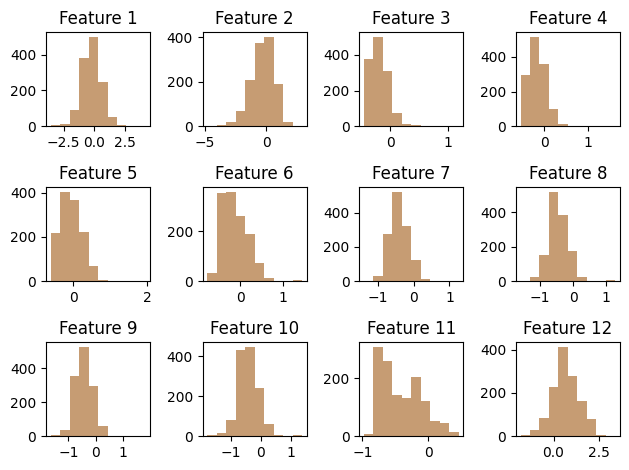

Percentage of positive samples: Ellipsis


In [6]:
#################################################
## TODO for students:
# Fill in the code in empty places to remove this error
# raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
#################################################

# Separate the positive and negative classes
pos_inds = np.where(y_train == ...)  # Indices of positive class (hint: i.e positive class will have y_train as 1)
neg_inds = np.where(y_train == ...)  # Indices of negative class (hint: i.e positive class will have y_train as 0)

# Create subplots for each feature
for i in range(12):
    plt.subplot(3, 4, i+1)  # Create a subplot
    # Plot histograms of the positive and negative classes for the current feature
    n, bins, patches = plt.hist(X_train[:, i][...], alpha=.5)  # Histogram of the positive class
    plt.hist(X_train[:, i][...], bins=bins, alpha=.5)         # Histogram of the negative class
    plt.title(f"Feature {i+1}")  # Set the title of the subplot to the current feature number

plt.tight_layout()  # Adjust spacing between subplots
plt.show()          # Display the subplots

print('Percentage of positive samples: ' + str(...))  #hint calculate % by (number of positive/(number of positive + number of negative)); can use len to calculate no

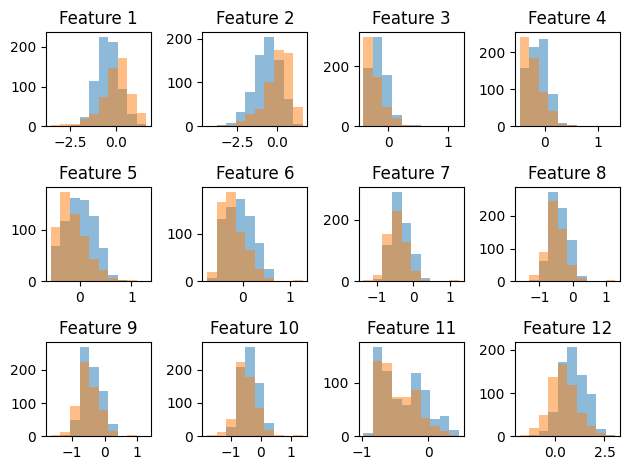

Percentage of positive samples: 0.5


In [7]:
# to_remove solution


# Separate the positive and negative classes
pos_inds = np.where(y_train == 1)  # Indices of positive class
neg_inds = np.where(y_train == 0)  # Indices of negative class

# Create subplots for each feature
for i in range(12):
    plt.subplot(3, 4, i+1)  # Create a subplot
    # Plot histograms of the positive and negative classes for the current feature
    n, bins, patches = plt.hist(X_train[:, i][pos_inds], alpha=.5)  # Histogram of the positive class
    plt.hist(X_train[:, i][neg_inds], bins=bins, alpha=.5)         # Histogram of the negative class
    plt.title(f"Feature {i+1}")  # Set the title of the subplot to the current feature number

plt.tight_layout()  # Adjust spacing between subplots
plt.show()          # Display the subplots

print('Percentage of positive samples: ' + str(len(pos_inds)/(len(pos_inds)+len(neg_inds))) )

<details>
<summary> <font color='orangered'>Click here description of histogram  </font></summary>

The plot generated shows the histograms of the positive and negative classes for each feature of the dataset. Each subplot represents a single feature and shows the distribution of values for that feature across the positive and negative classes. The histograms of the positive and negative classes are overlaid on each other with different colors for better comparison. The title of each subplot indicates the corresponding feature number.

By examining the histograms, we can gain insights into the relationship between each feature and the target variable (positive or negative class). For example, we can observe whether a particular feature has a similar distribution across both classes or if there is a significant difference in the distribution for the positive and negative classes. This can help us decide which features are more relevant for predicting the target variable and may be useful for feature selection or engineering. Additionally, the percentage of positive samples is printed, which gives us an idea of the class balance in the dataset.

### Think! 1.2 : Looking at features by class label 🧠💭

Based on these plots, do you think the final feature would be useful for identifying crops? What about second to last?

---
## (Bonus) **Section 1.3: Visualization of correlation between the features**
---



Looking at how different features of the data relate to each other can help us better understand the data and can be important when thinking about modeling building.

### Visualisation 1.3.1 : Plot Heatmap
First we produce a heatmap showing the correlation coefficients between the features, with blue indicating negative correlation and red indicating positive correlation. 

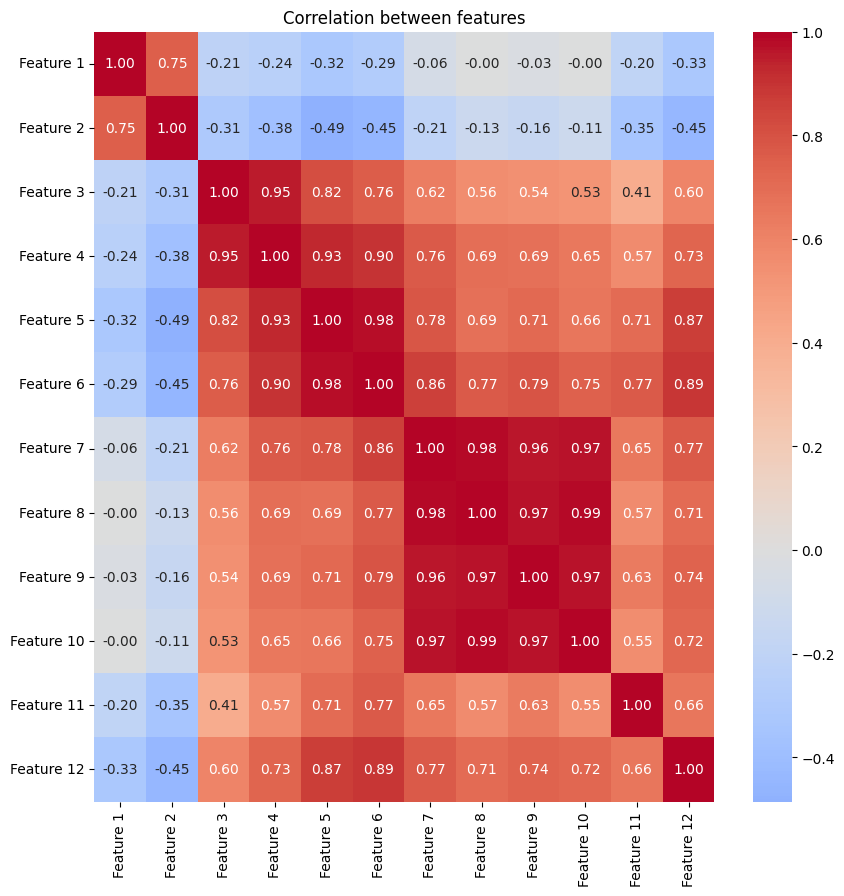

In [8]:
import seaborn as sns
# Calculate the correlation matrix
corr = np.corrcoef(X_train, rowvar=False)

# Plot the correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt='.2f',
            xticklabels=[f"Feature {i+1}" for i in range(12)],
            yticklabels=[f"Feature {i+1}" for i in range(12)])
ax.set_title("Correlation between features")
plt.show()

<details>
<summary> <font color='orangered'>But what is Correlation coefficient? 🤷‍♂️  </font></summary>

Correlation coefficients represent the strength and direction of the relationship between two variables. They range from -1 to +1, with +1 indicating a strong positive correlation, -1 indicating a strong negative correlation, and 0 indicating no correlation. In a heatmap, colors represent the correlation values, with darker colors indicating stronger correlations.



The correlation coefficient summarizes the relationship between two features. We can see this relationship more directly by plotting scatter plots of all the training data points. 

### Visualisation 1.3.2 : Plot Scatter plots
In this example, we create a 12x12 grid of subplots, with each subplot showing a scatter plot of two features. The color of the dots in the scatter plot represents the label of the data point (y_train). We set the cmap parameter of plt.scatter to 'bwr' to use a colormap that goes from blue for negative labels to red for positive labels.

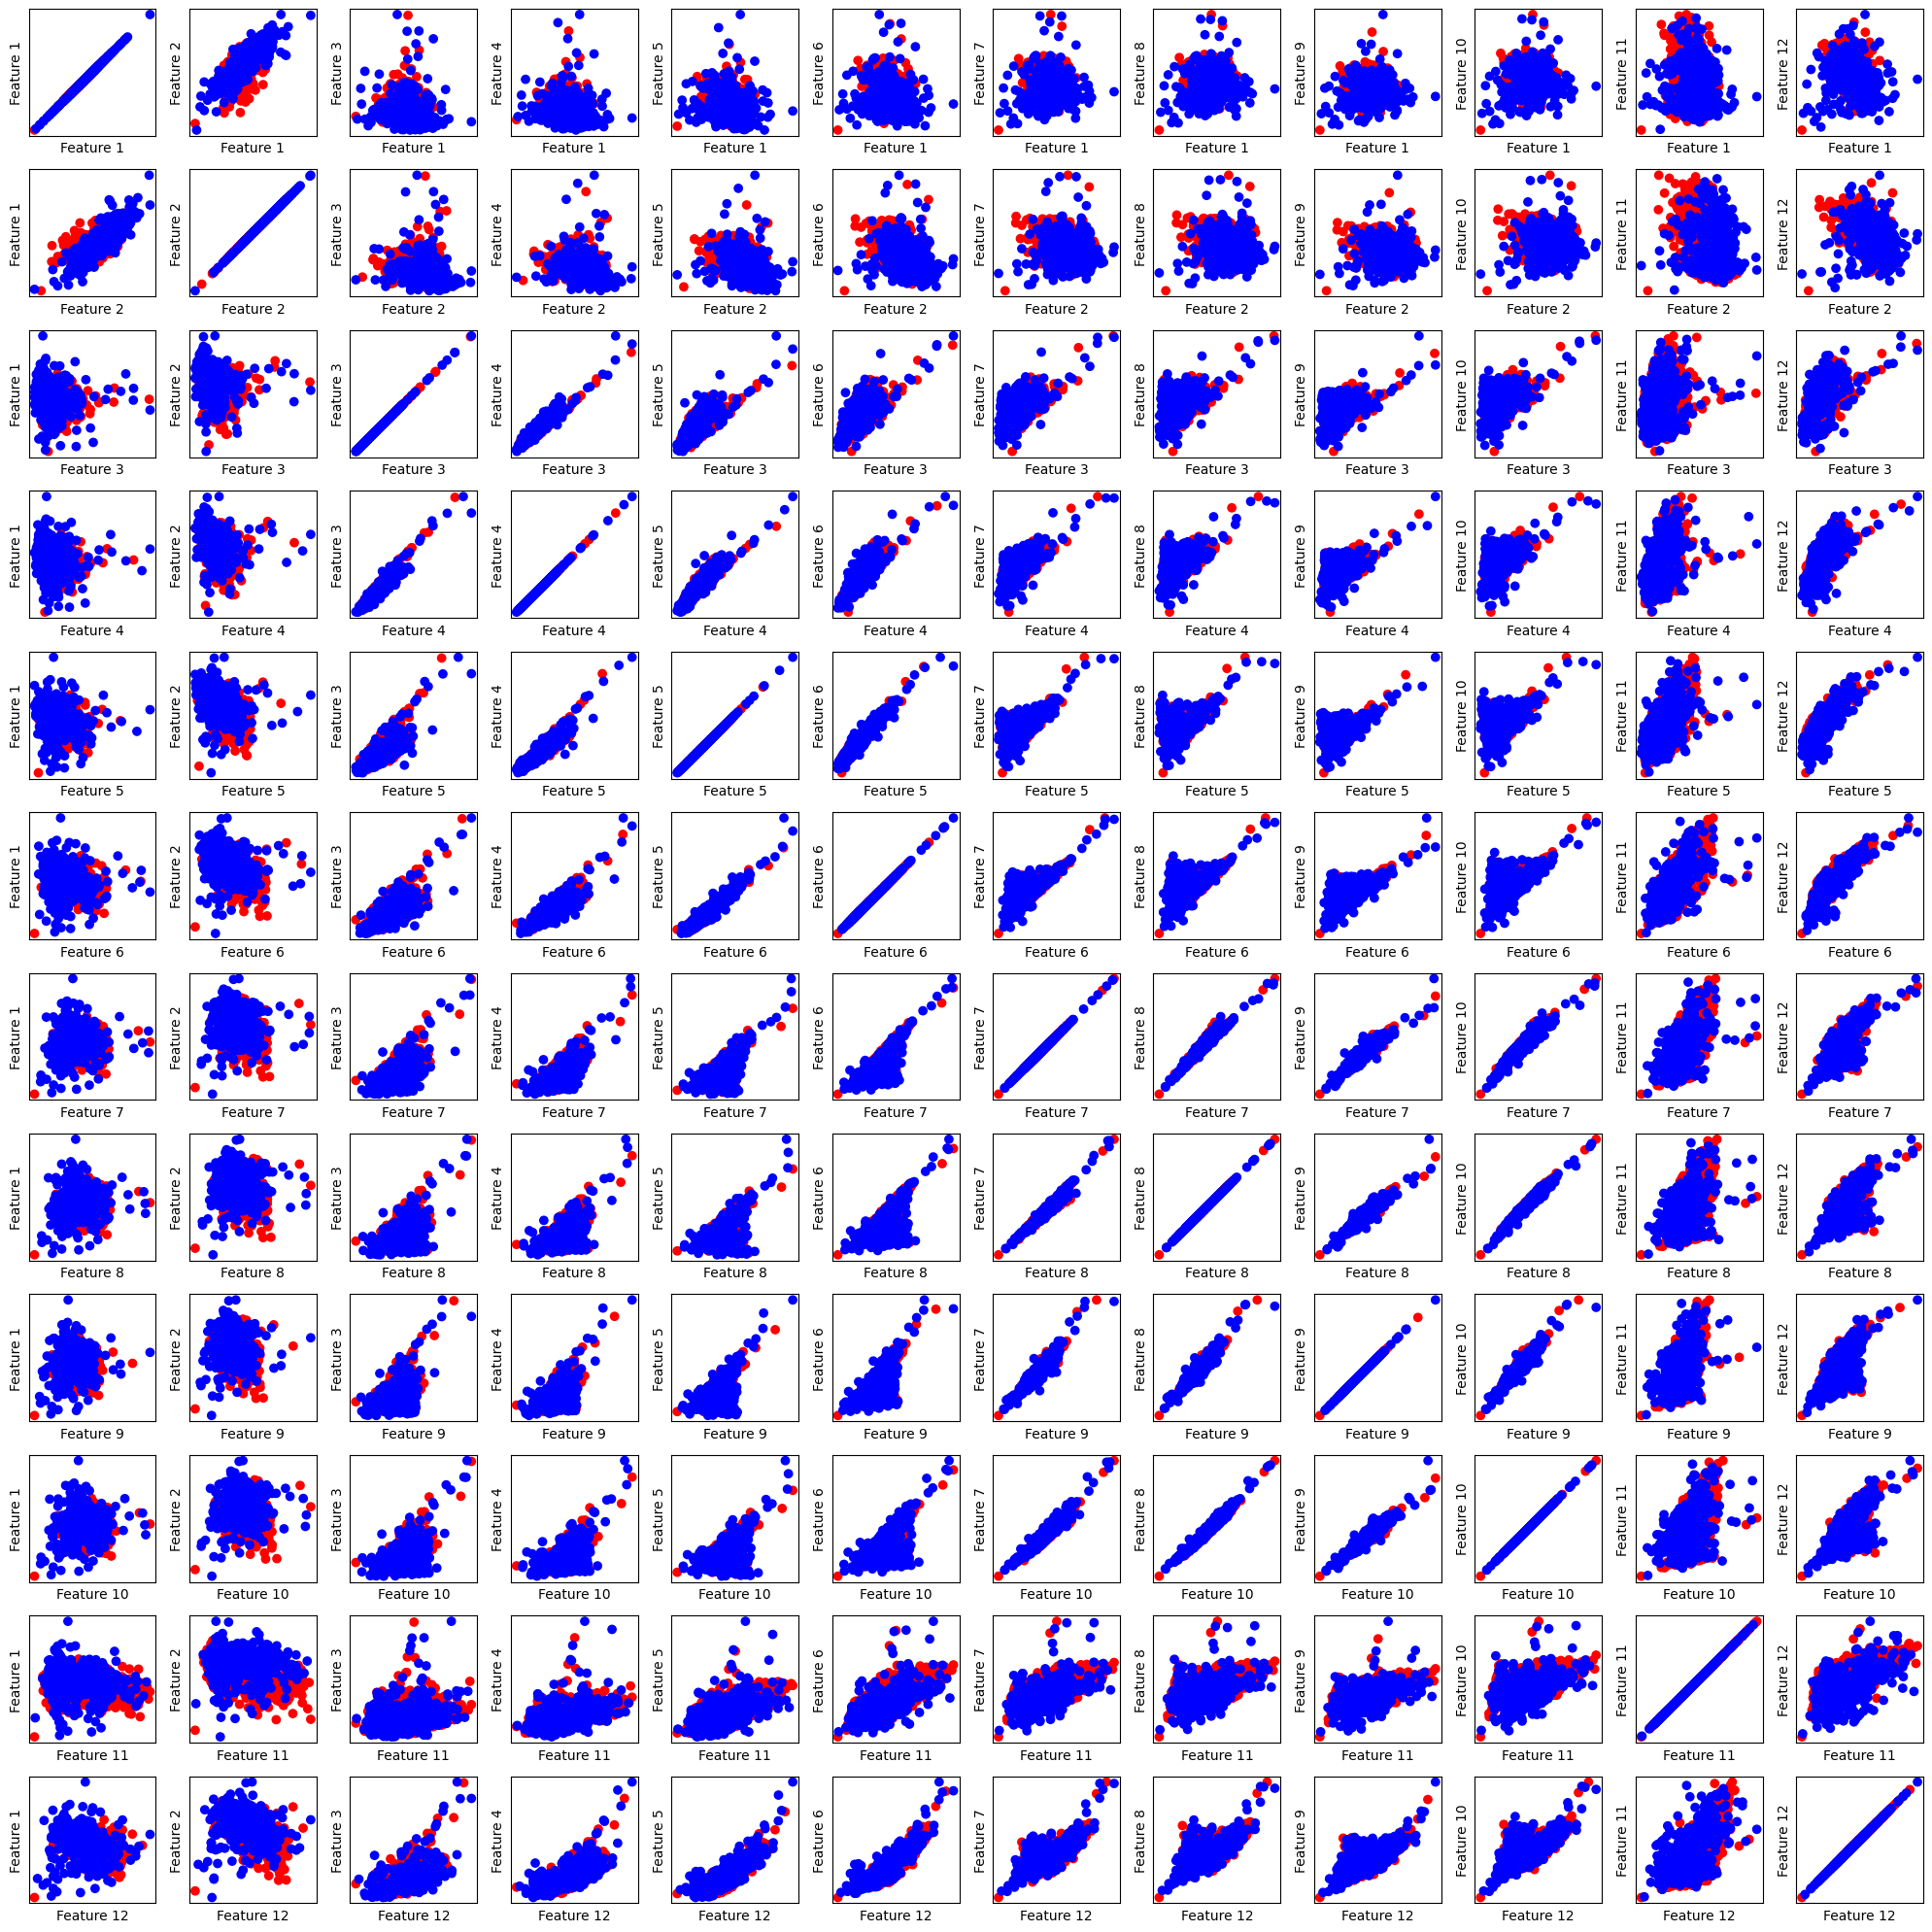

In [9]:
# Plot the data using scatter plots
fig, axs = plt.subplots(12, 12, figsize=(20, 20))
for i in range(12):
    for j in range(12):
        axs[i, j].scatter(X_train[:, i], X_train[:, j], c=y_train, cmap='bwr')
        axs[i, j].set_xlabel(f"Feature {i+1}")
        axs[i, j].set_ylabel(f"Feature {j+1}")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()

### Think!: Reflecting on correlations

Based on what you know about remote sensing and hyperspectral data, does it make sense that some pairs of features may be more correlated than others?



---


# **Section 2 : Logistic Regression on Crops Dataset**

---



Now that we understand our remote sensing data set we can train a model to classify each point as either containing or not containing crops. The data is already separated into training and test sets. Use what you've learned to train a logistic regression model on the training data. Evaluate the model separately on both the training set and test set according to the overall classification accuracy. 



---


## Section 2.1: Model Fitting on Data

---
In the following section, we will be using the data loaded in the previous section. Specifically, we have the training data in the variables `X_train` and `y_train`, and the testing data in the variables `X_test` and `y_test`.


### Coding Exercise 2.1: Fitting a Logistic Regression Model and Evaluation using scikit-learn
In this exercise, you will use `LogisticRegression` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to train a logistic regression model on the Togo crops dataset. First, fit the model to the training data, and then evaluate its accuracy on both the training and test data using the `.score()` method. Finally, print the training and test accuracy scores.

In [10]:
def evaluate_model(X_train, y_train, X_test, y_test):
    """
    Fits a logistic regression model to the training data and evaluates its accuracy on the training and test sets.

    Parameters:
    X_train (numpy.ndarray): The feature data for the training set.
    y_train (numpy.ndarray): The target data for the training set.
    X_test (numpy.ndarray): The feature data for the test set.
    y_test (numpy.ndarray): The target data for the test set.

    Returns:
    tuple: A tuple containing the training accuracy and test accuracy of the trained model.
    """

    #################################################
    ## TODO for students: Fits a logistic regression model to the training data and evaluates its accuracy on the training and test sets ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
    #################################################

    # Create an instance of the LogisticRegression class and fit it to the training data
    trained_model = ... #todo

    # Calculate the training and test accuracy of the trained model
    train_accuracy = ... #todo
    test_accuracy = ... #todo

    # Return the trained_model, training and test accuracy of the trained model
    return trained_model,train_accuracy, test_accuracy

## Uncomment the code below to test your function
#trained_model, train_acc, test_acc = evaluate_model(X_train, y_train, X_test, y_test)
#print('Training Accuracy: ', train_acc)
#print('Test Accuracy: ', test_acc)





```
The result should look like: 
Training Accuracy:  0.7511627906976744  
Test Accuracy:  0.7352941176470589
```



In [11]:
#to_remove solution

def evaluate_model(X_train, y_train, X_test, y_test):
    """
    Fits a logistic regression model to the training data and evaluates its accuracy on the training and test sets.

    Parameters:
    X_train (numpy.ndarray): The feature data for the training set.
    y_train (numpy.ndarray): The target data for the training set.
    X_test (numpy.ndarray): The feature data for the test set.
    y_test (numpy.ndarray): The target data for the test set.

    Returns:
    tuple: A tuple containing the training accuracy and test accuracy of the trained model.
    """
    # Create an instance of the LogisticRegression class and fit it to the training data
    trained_model = LogisticRegression().fit(X_train, y_train)

    # Calculate the training and test accuracy of the trained model
    train_accuracy = trained_model.score(X_train, y_train)
    test_accuracy = trained_model.score(X_test, y_test)


    # Return the trained_model, training and test accuracy of the trained model
    return trained_model,train_accuracy, test_accuracy

## Uncomment the code below to test your function
trained_model, train_acc, test_acc = evaluate_model(X_train, y_train, X_test, y_test)
print('Training Accuracy: ', train_acc)
print('Test Accuracy: ', test_acc)

Training Accuracy:  0.7511627906976744
Test Accuracy:  0.7352941176470589




---

## Section 2.2:  Further Evaluation of Performance
---

As discussed in the video,in some cases, overall accuracy of a machine learning model can be misleading, as it may not reveal how the model is performing in different areas. **Precision** and **recall** are two important metrics that can help evaluate the performance of a model in terms of its ability to correctly identify positive cases (precision) and to identify all positive cases (recall).

In this section, we will calculate precision and recall on the test set of our model using scikit-learn's built-in evaluation functions: `precision_score()` and `recall_score()`. For more information on these functions, please refer to their documentation : [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)





### Coding Exercise 2.2:  Evaluating Performance with Precision and Recall
In this exercise, you will evaluate the performance of a machine learning model using precision and recall metrics. We will provide you with a trained model, a test set X_test and its corresponding labels y_test. Your task is to use scikit-learn's built-in evaluation functions, precision_score() and recall_score(), to calculate the precision and recall on the test set. Then, you will print the results.

To complete this exercise, you will need to:
 
- Use the trained model to make predictions on the test set.  
- Calculate the recall score and precision score on the test set using scikit-learn's recall_score() and precision_score() functions, respectively.  


In [12]:
def evaluate_model_performance(trained_model, X_test, y_test):
    """
    Evaluate the performance of a trained model on a given test set suing recall and precision

    Parameters:
    trained_model (sklearn estimator): A trained scikit-learn estimator.
    X_test (array-like): Test input data.
    y_test (array-like): True labels for the test data.

    Returns:
    test_recall (float): The recall score on the test set.
    test_precision (float): The precision score on the test set.
    """

    #################################################
    ## TODO for students:Fill in the blank to use recall and precision.##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
    #################################################

    # Use the trained model to make predictions on the test set hint: use predict
    pred_test = ...

    #fill in the blank and uncommnet the cod eline
    # Calculate the recall and precision scores on the test set
    # test_recall = skm. .... #hint: call recall suing skm
    # test_precision = skm.   #hint: call preicision using skm


    # Return the recall and precision scores
    return ..., ...

# Evaluate the performance of the trained model on the test set
## Uncomment the code below to test your function
#test_recall, test_precision = evaluate_model_performance(trained_model, X_test, y_test)
# Print the results
#print('Test Recall: ', test_recall)
#print('Test Precision: ', test_precision)

In [13]:
#to_remove

def evaluate_model_performance(trained_model, X_test, y_test):
    """
    Evaluate the performance of a trained model on a given test set.

    Parameters:
    trained_model (sklearn estimator): A trained scikit-learn estimator.
    X_test (array-like): Test input data.
    y_test (array-like): True labels for the test data.

    Returns:
    test_recall (float): The recall score on the test set.
    test_precision (float): The precision score on the test set.
    """
    # Use the trained model to make predictions on the test set
    pred_test = trained_model.predict(X_test)

    # Calculate the recall and precision scores on the test set
    test_recall = skm.recall_score(y_test, pred_test)
    test_precision = skm.precision_score(y_test, pred_test)

    # Return the recall and precision scores
    return test_recall, test_precision

# Evaluate the performance of the trained model on the test set
## Uncomment the code below to test your function
test_recall, test_precision = evaluate_model_performance(trained_model, X_test, y_test)
print('Test Recall: ', test_recall)
print('Test Precision: ', test_precision)


Test Recall:  0.7830188679245284
Test Precision:  0.5886524822695035


<details>
<summary> <font color='orange'>But what is Precision and Recall? 🙋‍♂️  </font>

</summary>Precision and recall are two commonly used metrics in binary classification tasks.

Precision measures the accuracy of positive predictions made by a model. It is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). A high precision indicates a low false positive rate, meaning that when the model predicts a positive outcome, it is likely to be correct.

Recall, also known as sensitivity or true positive rate, measures the ability of a model to identify positive instances correctly. It is the ratio of true positive predictions to the total number of actual positive instances (true positives + false negatives). A high recall indicates a low false negative rate, meaning that the model is effective at capturing positive instances.

In summary, precision focuses on the accuracy of positive predictions, while recall focuses on the completeness of capturing positive instances. Both metrics are important and need to be balanced depending on the specific application or problem.

### Think! 2.2: Reflecting on performance metrics 

Looking at the results on the test data, which is your model better at: catching true crops that exist or not labeling non-crops as crops? 

---
## Section 2.3 :  Another feature importance method
---




Create a series of new datasets, each of which contains only 11 out of the 12 indepedent variables. Train and evaluate the accuracy of models using these different reduced datasets. Comparing the performances of these different models is one way of trying to understand which input features are most important for correct classification. Try also training a series of models that only use one feature at a time. According to these results, are there any features that seem especially useful for performance?

In [14]:
def calculate_performance(X_train, X_test, y_train, y_test):
    """
    Calculates performance with missing one features and only one feature using logistic regression.

    Args:
        X_train (ndarray): The training data.
        X_test (ndarray): The testing data.
        y_train (ndarray): The training labels.
        y_test (ndarray): The testing labels.

    Returns:
        missing_feature_performance (list): A list of performance scores for each missing feature.
        only_feature_performance (list): A list of performance scores for each individual feature.
    """

    #################################################
    ## TODO for students:Fill in the blank with appropriate code ##
    # Fill out function and remove the line below
    # raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
    #################################################

    missing_feature_performance = []  # Create empty list to store performance scores for each missing feature
    only_feature_performance = []  # Create empty list to store performance scores for each individual feature

    for feature in range(X_train.shape[1]):  # Iterate through each feature in the dataset
        # Remove the feature from both the training and test set
        X_train_reduced = np.delete(X_train, feature, 1)  # Remove feature from training set
        X_test_reduced = np.delete(X_test, feature, 1)  # Remove feature from test set
        reduced_trained_model = LogisticRegression().fit(..., ...)  # Train a logistic regression model on the reduced training set
        # missing_feature_performance.append(reduced_trained_model.score(..., ....))  # Calculate the score on the reduced test set and append to list

        # Select only the feature from both the training and test set
        X_train_reduced = X_train[:, feature].reshape(-1, 1)  # Select only feature from training set
        X_test_reduced = X_test[:, feature].reshape(-1, 1)  # Select only feature from test set
        # reduced_trained_model = LogisticRegression().fit(..., ....)  # Train a logistic regression model on the reduced training set
        only_feature_performance.append(reduced_trained_model.score(..., ...))  # Calculate the score on the reduced test set and append to list

    return missing_feature_performance, only_feature_performance

## Uncomment the code below to test your function
#missing_feature_performance, only_feature_performance = calculate_performance(X_train, X_test, y_train, y_test) # Call calculate_performance() function with the training and testing data and the corresponding labels
#plot_feature_performance(missing_feature_performance, only_feature_performance) # Plot the performance scores for each missing feature and each individual feature

*Example output:*

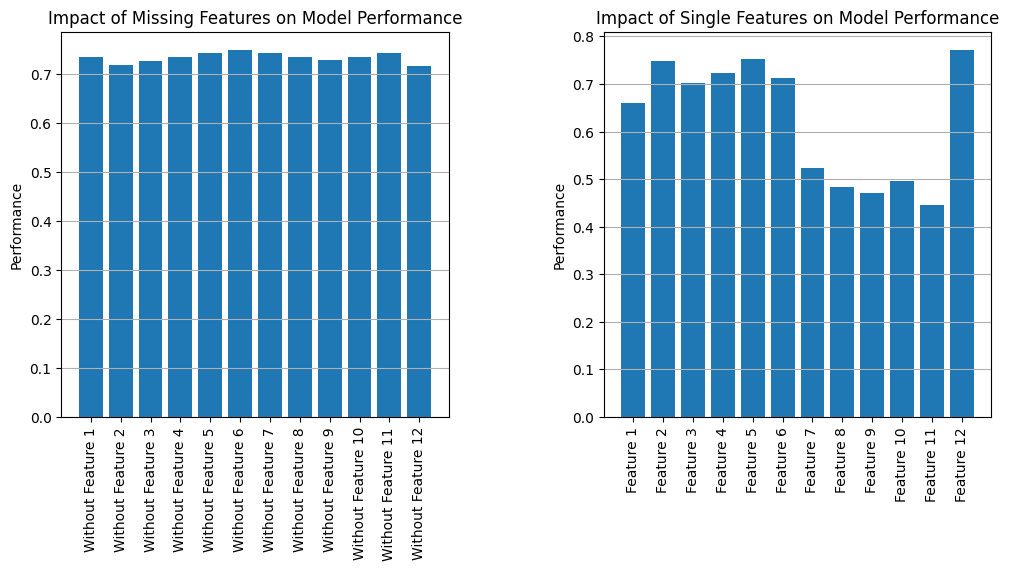

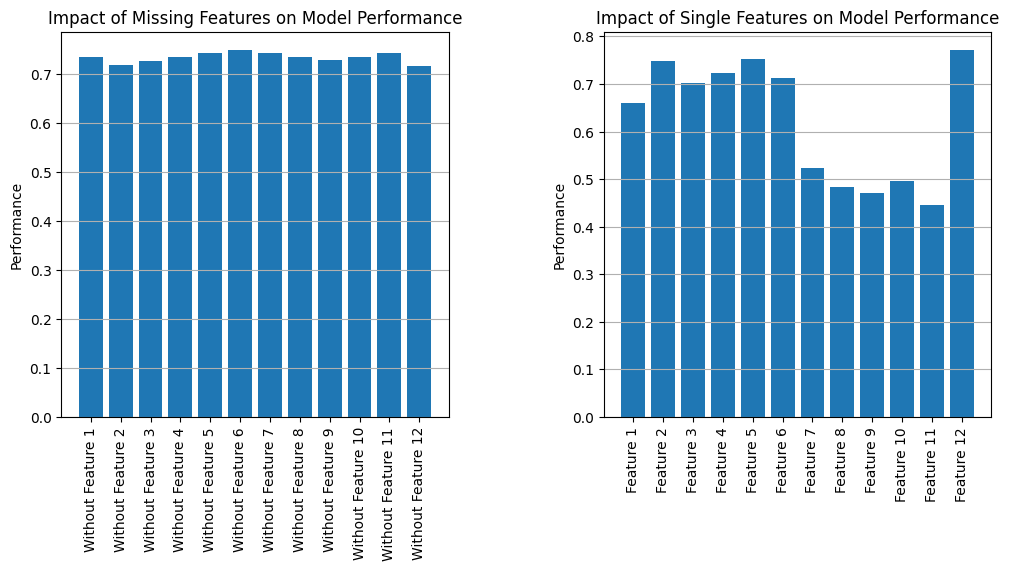

In [15]:
#to_remove

def calculate_performance(X_train, X_test, y_train, y_test):
    """
    Calculates performance with missing features and only one feature using logistic regression.

    Args:
        X_train (ndarray): The training data.
        X_test (ndarray): The testing data.
        y_train (ndarray): The training labels.
        y_test (ndarray): The testing labels.

    Returns:
        missing_feature_performance (list): A list of performance scores for each missing feature.
        only_feature_performance (list): A list of performance scores for each individual feature.
    """

    missing_feature_performance = []  # Create empty list to store performance scores for each missing feature
    only_feature_performance = []  # Create empty list to store performance scores for each individual feature

    for feature in range(X_train.shape[1]):  # Iterate through each feature in the dataset
        # Remove the feature from both the training and test set
        X_train_reduced = np.delete(X_train, feature, 1)  # Remove feature from training set
        X_test_reduced = np.delete(X_test, feature, 1)  # Remove feature from test set
        reduced_trained_model = LogisticRegression().fit(X_train_reduced, y_train)  # Train a logistic regression model on the reduced training set
        missing_feature_performance.append(reduced_trained_model.score(X_test_reduced, y_test))  # Calculate the score on the reduced test set and append to list

        # Select only the feature from both the training and test set
        X_train_reduced = X_train[:, feature].reshape(-1, 1)  # Select only feature from training set
        X_test_reduced = X_test[:, feature].reshape(-1, 1)  # Select only feature from test set
        reduced_trained_model = LogisticRegression().fit(X_train_reduced, y_train)  # Train a logistic regression model on the reduced training set
        only_feature_performance.append(reduced_trained_model.score(X_test_reduced, y_test))  # Calculate the score on the reduced test set and append to list

    return missing_feature_performance, only_feature_performance

## Uncomment the code below to test your function
missing_feature_performance, only_feature_performance = calculate_performance(X_train, X_test, y_train, y_test) # Call calculate_performance() function with the training and testing data and the corresponding labels
plot_feature_performance(missing_feature_performance, only_feature_performance) # Plot the performance scores for each missing feature and each individual feature

<details>
<summary> <font color='yellow'>Click here for interpretation of plot  </font><font color=' red'>(first try to understand by yourself)  </font></summary>
The plot shows the performance of the logistic regression model when each feature is removed from the dataset (missing feature performance) and when each feature is used individually as the only predictor (only feature performance). The height of each bar represents the performance score for the corresponding model. Therefore, in the left plot, the lower the bar the more important the feature is (performance drops when that feature is not included). In the right plot, the higher the bar the more important the feature is (the model can perform well with that feature alone).



---


## (Bonus) Section 2.4: Compare to Permutation Feature importance

---




Use what you learned to also implement the permutation method of estimating feature importance on this model. 

### Coding Exercise 2.4 : Evaluate and plot feature importance with the permutation method
For this exercise, you have to evaluate and plot feature importance with the permutation method using the `permutation_importance` function from [sklearn.inspection](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

Here are the steps to follow:

1. Import `permutation_importance` from `sklearn.inspection`.
2. Calculate the permutation feature importance using trained_model, X_test, and y_test.
3. Set the number of repeats to 10 and random state to 0.

In [16]:
#################################################
## TODO for students:
# Fill in the code in empty places to remove this error
# raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
#################################################

# Evaluate and plot feature importance with the permutation method

# import permutation_importance from sklearn.inspection
from sklearn.inspection import permutation_importance

# calculate the permutation feature importance using trained_model, X_test and y_test
#set n_repeats to 10 and random_state to 0
#todo fill in the balk and uncomment line below
#perm_feat_imp = permutation_importance(trained_model, X_test,y_test, n_repeats= ..., random_state=...)

#### Uncomment the code below to test your solution
#plot_permutation_feature_importance(perm_feat_imp, X_test)

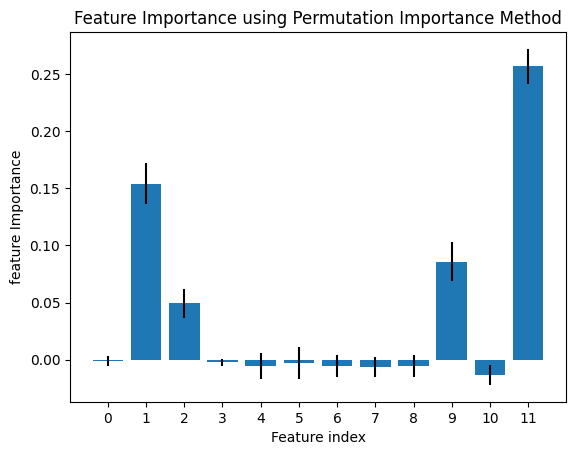

In [17]:
#to_remove solution
from sklearn.inspection import permutation_importance

perm_feat_imp = permutation_importance(trained_model, X_test,y_test,
                           n_repeats=10,
                           random_state=0)


plot_permutation_feature_importance(perm_feat_imp, X_test)

<details>
<summary> <font color='yellow'>Click here for description of code  </font></summary>
The code is performing feature importance analysis using the permutation importance method. This method is used to determine the importance of features in a machine learning model by shuffling the values of each feature and measuring the effect on the model's performance.

The first step is to import the necessary libraries including `sklearn` for the permutation importance method. Then the permutation importance is computed using the `permutation_importance()` function, which takes the trained model, test data, and number of repeats as input.

The results of the permutation importance are stored in the `perm_feat_imp` variable.

Finally, a bar plot is generated using Matplotlib to visualize the feature importance values. 

<details>
<summary> <font color='yellow'>Click here for interpretation of plot  </font><font color=' red'>(first try to understand by yourself)  </font></summary>
The plot generated shows the feature importance scores using the permutation importance method. Each bar represents the importance of a feature, with the height of the bar indicating the mean importance score across all permutations and the error bar indicating the standard deviation.

Features with higher importance scores are considered more important in predicting the target variable than those with lower scores. You can use this information to identify the most important features in your dataset and potentially reduce the dimensionality of your model by removing the least important features.

In this particular plot, the x-axis represents the feature index (or feature number), and the y-axis represents the feature importance score.

---
## Section 2.5 : Reflection 
---



### Think! : Comparing importance measures 

Do these methods return similar results as to what features are most important? If not, why might they not? 



---


# **Section 3 : Artificial neural networks on crops dataset**

---



An artificial neural network (ANN) is a computational model inspired by the structure and function of the human brain. It consists of multiple interconnected layers of artificial neurons that learn to recognize patterns and make predictions from input data. 

The input layer receives the data, and the output layer produces the model's predictions. The hidden layers between the input and output layers are where the network's computations take place. Each node in a hidden layer performs a weighted sum of the inputs and applies an activation function to the result, producing an output that is sent to the next layer. The weights and biases of the nodes in the network are learned during training, where the model is fed data and adjusts its weights and biases to minimize the error between its predictions and the true values.

ANNs have been successfully applied to a variety of climate-related problems, such as climate modeling, extreme weather event prediction, and crop yield forecasting. ANNs can also help to overcome some of the limitations of traditional statistical methods by allowing for non-linear relationships between variables and handling large, complex datasets.

---
## Section 3.1:  Training an artificial neural network on crops data
---


As discussed before, there are usually multiple possible ways to solve a data science problem. Here we will train an artificial neural network (ANN) to perform binary classifcation on our remote sensing crops data set. 

In the following section, we will be using the data loaded in the previous section. Specifically, we have the training data in the variables `X_train` and `y_train`, and the testing data in the variables `X_test` and `y_test`.

Small artificial neural networks can be trained in scitkit-learn just like other models. Use [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) with default parameters to train a model on the crops training set and evaluate its accuracy on both the training and test sets. (MLP stands for multi-layer perceptron, another name for a simple artificial neural network). 

In [18]:
#################################################
## TODO for students: Import and fit MLP on crop data
# Fill in the code in empty places and comment out the line given below
# raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
#################################################

# Import the MLPClassifier from the neural_network module in the sklearn library
from sklearn.neural_network import MLPClassifier

# Set a random seed to ensure reproducibility of results
np.random.seed(144)

# Fit the MLPClassifier model on the training data
# trained_model = ....    # todo : write code to fit MLPClassifier on train data and uncomment; hint call .fit(,) on MLPClassifier() 

# Print the training accuracy and test accuracy of the model
print(' Training Accuracy: ',  trained_model.score(X_train,y_train))
print(' Test Accuracy:     ',  trained_model.score(X_test,y_test))

 Training Accuracy:  0.7511627906976744
 Test Accuracy:      0.7352941176470589




```
# After successfull implementation your result should look like this
 Training Accuracy:  0.7875968992248062
 Test Accuracy:      0.7189542483660131
```



In [19]:
#to_remove solution

# Import the MLPClassifier from the neural_network module in the sklearn library
from sklearn.neural_network import MLPClassifier

# Set a random seed to ensure reproducibility of results
np.random.seed(144)

# Fit the MLPClassifier model on the training data
trained_model = MLPClassifier().fit(X_train, y_train)

# Print the training accuracy and test accuracy of the model
print(' Training Accuracy: ',  trained_model.score(X_train,y_train))
print(' Test Accuracy:     ',  trained_model.score(X_test,y_test))

 Training Accuracy:  0.7875968992248062
 Test Accuracy:      0.7189542483660131


### Think! 3.1: Understanding the model
Does the ANN perform better or worse than the logistic regression model? Does the result surprise you?



---


## Section 3.2:  Overfitting in ANNs


---


Our ANN model has better training performance but worse test performance than the linear regression model. As we saw previously, high training data performance but poor test data performance could be a sign of overfitting. Overfitting happens when a model has too many free parameters, which it uses to 'memorize' the relationships between inputs and outputs in the training set. In this way, what the model learns is too specific to the training data and won't be helpful on new data. 

One way to cause overfitting is to use a large model. Use the hidden_layer_sizes parameter of MLPClassifier to vary the number of units in the hidden layer in your ANN. Plot the training and test performance as a function of the number of hidden units. Note how training performance rises as test performance does not.  


### Exercise 3.2 : Visualizing the Impact of Hidden Units on the Performance of a Multi-Layer Perceptron Classifier

**Objective**: In this exercise, you are required to fill in the missing code in the mlp_performance function. The function is supposed to train multiple MLP classifiers with different numbers of hidden units and return the training and testing accuracy for each classifier.

It may take a few minutes for this to run. While you wait, discuss what adding more units really means. What does each hidden unit do and how does having more give the model higher capacity? 


In [20]:
#@markdown  *Execute this cell to enable the plotting function to be used for plotting performance of our model in next cell: `plot_mlp_performance`*

def plot_mlp_performance(hidden_units, train_accuracy, test_accuracy):
    """
    Plot the performance of the Multi-Layer Perceptron (MLP) model with varying hidden units.

    Args:
    hidden_units (range): A range of integers representing the different number of hidden units.
    train_accuracy (list): A list of floats representing the training accuracy for each number of hidden units.
    test_accuracy (list): A list of floats representing the testing accuracy for each number of hidden units.

    Returns:
    None
    """

    # Create a figure and axis object with specified size
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training accuracy as a function of number of hidden units
    ax.plot(hidden_units, train_accuracy, marker='o', label='Training Accuracy', color='navy', alpha=0.8, linewidth=2)

    # Plot the testing accuracy as a function of number of hidden units
    ax.plot(hidden_units, test_accuracy, marker='o', label='Testing Accuracy', color='crimson', alpha=0.8, linewidth=2)

    # Add a legend to the plot
    ax.legend()

    # Add a title to the plot
    ax.set_title('Performance of MLP with Varying Hidden Units', fontsize=16, fontweight='bold')

    # Add x-label to the plot
    ax.set_xlabel('Number of Hidden Units', fontsize=14)

    # Add y-label to the plot
    ax.set_ylabel('Accuracy', fontsize=14)

    # Set tick labels for x and y axes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add gridlines to the plot
    ax.grid(True, linestyle='--', alpha=0.5)

    # Remove top and right spines of the plot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Adjust the layout of the plot
    plt.tight_layout()

    # Display the plot
    plt.show()

In [21]:
def mlp_performance(X_train, y_train, X_test, y_test):
    """
    This function trains multiple MLP classifiers with different numbers of hidden units and returns the training and testing
    accuracy for each classifier.

    Args:
    X_train (ndarray): An array of shape (N_train, M) that contains the training data
    y_train (ndarray): An array of shape (N_train,) that contains the labels for the training data
    X_test (ndarray): An array of shape (N_test, M) that contains the testing data
    y_test (ndarray): An array of shape (N_test,) that contains the labels for the testing data

    Returns:
    tuple: A tuple of three arrays: hidden_units, train_accuracy, and test_accuracy
    """

    #################################################
    ## TODO for students:
    # Fill in the code in empty places to remove this error
    raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
    #################################################

    # Define the range of hidden units to test
    hidden_units = range(5, 300, 15)  # Test 5 to 300 hidden units in steps of 15

    # Create empty lists to store training and testing accuracy for different numbers of hidden units
    train_accuracy = []
    test_accuracy = []

    # Loop over different numbers of hidden units
    for units in hidden_units:
        # Set a seed for random number generation to ensure consistent results
        np.random.seed(144)

        # Create an MLP classifier with the current number of hidden units
        classifier = MLPClassifier(hidden_layer_sizes=(...))

        # Train the classifier on the training data
        classifier.fit(..., y_train)

        # Calculate the training and testing accuracy of the classifier
        train_acc = classifier.score(..., ...)
        test_acc = classifier.score(..., ...)

        # Add the training and testing accuracy to the corresponding lists
        train_accuracy.append(...)
        test_accuracy.append(...)

    return hidden_units, train_accuracy, test_accuracy

## Uncomment the code below to test your function
#Call mlp_performance function
#hidden_units, train_accuracy, test_accuracy = mlp_performance(X_train, y_train, X_test, y_test)
# Plot the training and testing accuracy as a function of the number of hidden units
#plot_mlp_performance(hidden_units, train_accuracy, test_accuracy)



```
# Correct implementation should result in plot like this
```
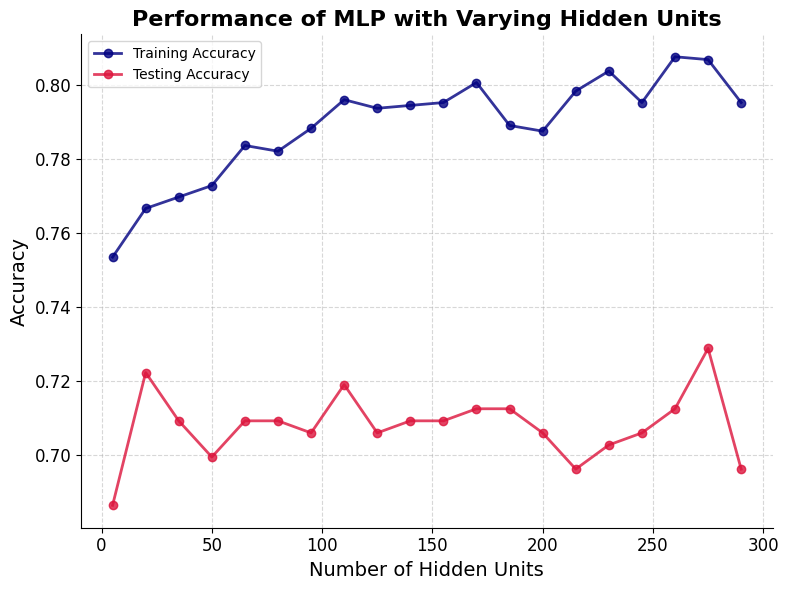



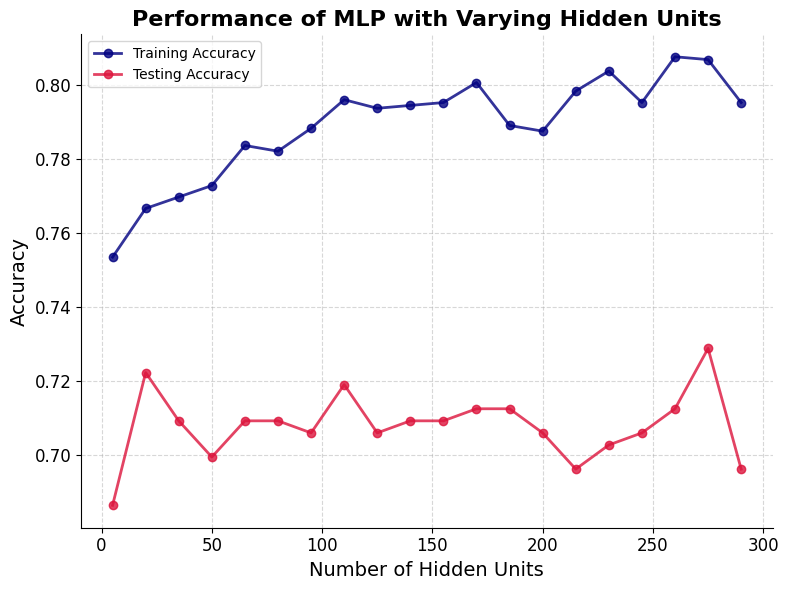

In [22]:
# to remove 
def mlp_performance(X_train, y_train, X_test, y_test):
    """
    This function trains multiple MLP classifiers with different numbers of hidden units and returns the training and testing
    accuracy for each classifier.

    Args:
    X_train (ndarray): An array of shape (N_train, M) that contains the training data
    y_train (ndarray): An array of shape (N_train,) that contains the labels for the training data
    X_test (ndarray): An array of shape (N_test, M) that contains the testing data
    y_test (ndarray): An array of shape (N_test,) that contains the labels for the testing data

    Returns:
    tuple: A tuple of three arrays: hidden_units, train_accuracy, and test_accuracy
    """


    # Define the range of hidden units to test
    hidden_units = range(5, 300, 15)  # Test 5 to 300 hidden units in steps of 15

    # Create empty lists to store training and testing accuracy for different numbers of hidden units
    train_accuracy = []
    test_accuracy = []

    # Loop over different numbers of hidden units
    for units in hidden_units:
        # Set a seed for random number generation to ensure consistent results
        np.random.seed(144)

        # Create an MLP classifier with the current number of hidden units
        classifier = MLPClassifier(hidden_layer_sizes=(units))

        # Train the classifier on the training data
        classifier.fit(X_train, y_train)

        # Calculate the training and testing accuracy of the classifier
        train_acc = classifier.score(X_train, y_train)
        test_acc = classifier.score(X_test, y_test)

        # Add the training and testing accuracy to the corresponding lists
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

    return hidden_units, train_accuracy, test_accuracy

## Uncomment the code below to test your function
#Call mlp_performance function
hidden_units, train_accuracy, test_accuracy = mlp_performance(X_train, y_train, X_test, y_test)
# Plot the training and testing accuracy as a function of the number of hidden units
plot_mlp_performance(hidden_units, train_accuracy, test_accuracy)

How do you interpret the plot above? What do you observe?

<details>
<summary> <font color='violet'>Hint  </font></summary>
The plot generated by the mlp_performance function shows the training and testing accuracy of a multi-layer perceptron classifier (MLP) as a function of the number of hidden units. The blue line shows the training accuracy, while the orange line shows the testing accuracy.       
As the number of hidden units increases, the training accuracy generally increases as well. However, the testing accuracy may not necessarily increase and may start to plateau or even decrease at some point. This indicates the model is overfitting, where it is learning the noise in the training data instead of the underlying pattern.



---


## Section 3.3:  Overfitting by learning too much

---



As the network is trained, it loops through all the training data repeatedly, updating its weights to make the network perform better on that data. Another way to induce overfitting is to let the network loop over the training data too many times. Repeat the above training experiment with the default number of hidden units but varying the number training epochs using the max_iter parameter. 

While you wait for this to run, you can continue your discussion about hidden units. 

### Exercise 3.3 : Training MLPClassifier with varying number of epochs and observing performance

In [23]:
#@markdown  *Execute this cell to enable the plotting function to be used for plotting performance of our model in next cell: `plot_training_performance`*


def plot_training_performance(train_perfs, test_perfs):
    """
    Plots the training and test performance against the number of training epochs.

    Args:
    train_perfs: list of floats representing the training performance for each epoch.
    test_perfs: list of floats representing the test performance for each epoch.
    """
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the training and test performance against the number of training epochs
    ax.plot(np.arange(5,500,20),train_perfs, label='Training Accuracy', linewidth=2, marker='o')
    ax.plot(np.arange(5,500,20),test_perfs, label='Test Accuracy', linewidth=2, marker='s')
    ax.set_title('Training and Test Performance vs. Number of Training Epochs', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Training Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True)

    # Add text annotation for maximum test accuracy
    max_test_acc = max(test_perfs)
    max_test_epoch = (np.argmax(test_perfs)*20)+5
    ax.annotate(f'Maximum test accuracy of {max_test_acc:.2f} at {max_test_epoch} epochs',
                xy=(max_test_epoch, max_test_acc),
                xytext=(max_test_epoch+50, max_test_acc-0.05),
                fontsize=12, fontweight='bold', color='green',
                arrowprops=dict(facecolor='green', shrink=0.05))

    # Show the plot
    plt.tight_layout()
    plt.show()

In [24]:
def train_epochs(X_train, y_train, X_test, y_test, start_epoch=5, end_epoch=500, step=20):
    """
    Train an MLPClassifier for a range of epochs and return the training and test accuracy for each epoch.

    Parameters:
    -----------
    X_train: array-like of shape (n_samples, n_features)
        Training input samples.
    y_train: array-like of shape (n_samples,)
        Target values for the training set.
    X_test: array-like of shape (n_samples, n_features)
        Test input samples.
    y_test: array-like of shape (n_samples,)
        Target values for the test set.
    start_epoch: int, optional
        The first epoch to train for. Default is 5.
    end_epoch: int, optional
        The last epoch to train for. Default is 500.
    step: int, optional
        The step size between epochs. Default is 20.

    Returns:
    --------
    tuple
        Two lists, the first containing the training accuracy for each epoch, and the second containing the test
        accuracy for each epoch.
    """

    #################################################
    ## TODO for students:
    # Fill in the code in empty places and then comment out the line given below
    raise NotImplementedError("Student exercise: Fill in the code in empty places to remove this error")
    #################################################

    # Initialize empty lists to store training and test performance
    train_accuracy = []
    test_accuracy = []

    # Loop through a range of epochs and train the MLPClassifier model for each epoch
    for m in range(start_epoch, end_epoch, step):
        # Set random seed for reproducibility
        np.random.seed(144)

        # Fit the MLPClassifier model to the training data for the current epoch
        trained_model = MLPClassifier(max_iter=m).fit(X_train, y_train)

        # Calculate and store the training and test accuracy for the current epoch
        train_accuracy.append(trained_model.score(X_train,y_train))
        test_accuracy.append(trained_model.score(X_test,y_test))

    # Return the lists of training and test performance for each epoch
    return train_accuracy, test_accuracy

## Uncomment the code below to test your function
#train_perfs, test_perfs = train_epochs(X_train, y_train, X_test, y_test) # Call the train_epochs function and store the returned values in variables train_perfs and test_perfs
#plot_training_performance(train_perfs, test_perfs) # Calling plotting function to plot the performance vs epochs plot



```
# Example Output
```
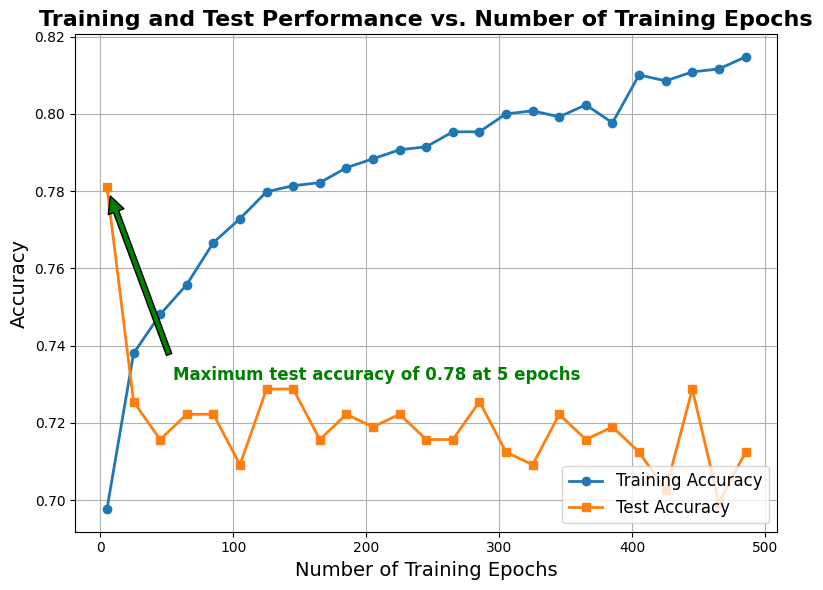


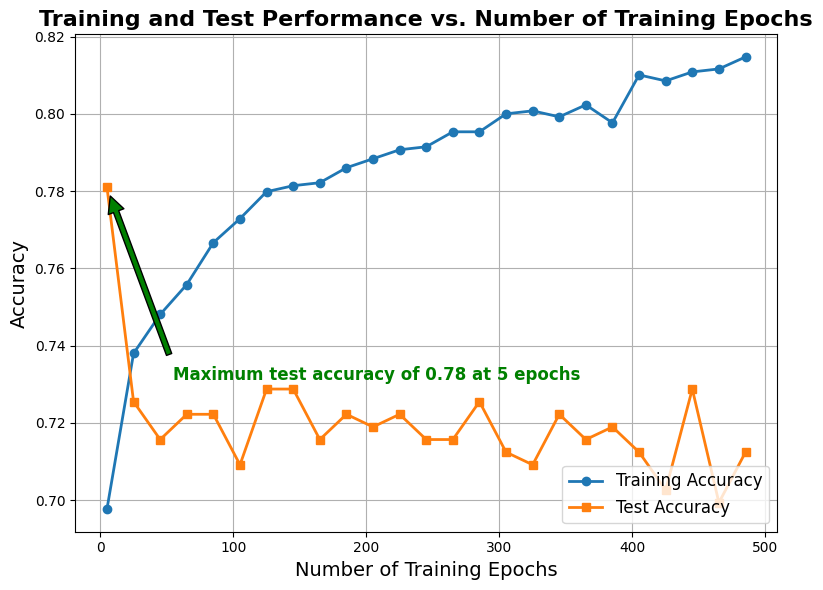

In [25]:
#to_remove

def train_epochs(X_train, y_train, X_test, y_test, start_epoch=5, end_epoch=500, step=20):
    """
    Train an MLPClassifier for a range of epochs and return the training and test accuracy for each epoch.

    Parameters:
    -----------
    X_train: array-like of shape (n_samples, n_features)
        Training input samples.
    y_train: array-like of shape (n_samples,)
        Target values for the training set.
    X_test: array-like of shape (n_samples, n_features)
        Test input samples.
    y_test: array-like of shape (n_samples,)
        Target values for the test set.
    start_epoch: int, optional
        The first epoch to train for. Default is 5.
    end_epoch: int, optional
        The last epoch to train for. Default is 500.
    step: int, optional
        The step size between epochs. Default is 20.

    Returns:
    --------
    tuple
        Two lists, the first containing the training accuracy for each epoch, and the second containing the test
        accuracy for each epoch.
    """

    # Initialize empty lists to store training and test performance
    train_accuracy = []
    test_accuracy = []

    # Loop through a range of epochs and train the MLPClassifier model for each epoch
    for m in range(start_epoch, end_epoch, step):
        # Set random seed for reproducibility
        np.random.seed(144)

        # Fit the MLPClassifier model to the training data for the current epoch
        trained_model = MLPClassifier(max_iter=m).fit(X_train, y_train)

        # Calculate and store the training and test accuracy for the current epoch
        train_accuracy.append(trained_model.score(X_train,y_train))
        test_accuracy.append(trained_model.score(X_test,y_test))

    # Return the lists of training and test performance for each epoch
    return train_accuracy, test_accuracy

## Uncomment the code below to test your function
# Call the train_epochs function and store the returned values in variables train_perfs and test_perfs
train_perfs, test_perfs = train_epochs(X_train, y_train, X_test, y_test)
# Calling plotting function to plot the performance vs epochs plot
plot_training_performance(train_perfs, test_perfs)

What did you observe?

<details>
<summary> <font color='Violet'>Hint!  </font></summary>

The plot generated shows the training and test accuracy of a neural network as the number of training epochs increases. The training accuracy generally increases with the number of epochs, while the test accuracy initially increases but eventually levels off or even decreases due to overfitting. The maximum test accuracy achieved and the epoch at which it occurs can also be seen on the plot.



---
## Section 3.4 : Reflection on Overfitting
---



### Think! 3.4: Preventing overfitting

Now that we saw what can cause overfitting, reflect on how to prevent it. In addition to controlling the number of hidden units and amount of training, are there any other ways to prevent overfitting? 



```
#  to_remove explanation

Solutions to handle overfitting include reducing model complexity, increasing dataset size, using regularization, or cross-validation. Ensemble models such as random forests also do inherently help control overfitting by averaging many different models
```





---


# **Summary**

The tutorial covered how to analyze and visualize the crop dataset, train a logistic regression model, and evaluate its performance using various metrics. Feature importance was also discussed, and two methods were explored. In addition, the tutorial covered training an artificial neural network on the crops dataset and preventing overfitting.

---





<p align='right'><font color='gree'>Congratulations!</font> 🎉  You have reached the end of Tutorial 3!!</p>